**Steps:**
- Take 20220228_20220828 as test data
- Groupby merchant abn & month
- Transaction merge w/ consumer SA2
- Take the most common SA2 to be merchant SA2

**Features:**
1. _External Data:_
- Income by SA2 (median AUD income & median age income)
- Age population by SA2 (age 20 - 55)
2. _Internal Data:_ 
- Tags (one hot encoding)
- Transaction frequency
- Number of new consumers during the specified month
- Number of active days
- Average growth % Month to Month per merchant 
- Fraud likeliness (wait for Andrew)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import countDistinct, col, date_format
import numpy as np
import pyspark.sql.functions as func
from pyspark.sql.functions import sum, avg, count, lag, date_sub, split
from pyspark.sql.window import Window
from pyspark.sql.types import (
    StringType,
    LongType,
    DoubleType,
    StructField,
    StructType,
    FloatType
)
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Start Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/04 20:33:46 WARN Utils: Your hostname, Patricks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.137 instead (on interface en0)
22/10/04 20:33:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/04 20:33:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/04 20:33:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# load data from ETL
df_trx_sa2 = spark.read.parquet('../data/curated/df_trx_sa2.parquet')
df_trx_sa2_test = spark.read.parquet('../data/curated/df_trx_sa2_test.parquet')

In [4]:
age = gpd.read_file("../data/abs/sa2_age.gml")
income = gpd.read_file("../data/abs/sa2_income.gml")

In [5]:
age.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2288 entries, 0 to 2287
Data columns (total 69 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   gml_id               2288 non-null   object  
 1   sa2_main16           2288 non-null   int64   
 2   state_code           2288 non-null   int64   
 3   state_name           2288 non-null   object  
 4   gccsa_code16         2288 non-null   object  
 5   gccsa_name16         2288 non-null   object  
 6   sa4_code16           2288 non-null   int64   
 7   sa4_name16           2288 non-null   object  
 8   sa3_code16           2288 non-null   int64   
 9   sa3_name16           2288 non-null   object  
 10  sa2_name16           2288 non-null   object  
 11  females_age_0_4      2288 non-null   int64   
 12  females_age_10_14    2288 non-null   int64   
 13  females_age_15_19    2288 non-null   int64   
 14  females_age_20_24    2288 non-null   int64   
 15  females_age_2

In [6]:
df_trx_sa2 = (df_trx_sa2.withColumn("order_year_month", 
                                date_format(col("order_datetime"), 'yyyy-MM')))
df_trx_sa2_test = (df_trx_sa2_test.withColumn("order_year_month", 
                                date_format(col("order_datetime"), 'yyyy-MM')))

---

In [7]:
df_trx_sa2.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- revenue: float (nullable = true)
 |-- order_year_month: string (nullable = true)



In [8]:
df_trx_sa2_test.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- revenue: float (nullable = true)
 |-- order_year_month: string (nullable = true)



In [9]:
# df_trx_sa2.show(1, vertical=True)

In [10]:
# df_trx_sa2_test.show(1, vertical=True)

In [11]:
# calculate population of age above 20
def get_age_pop(age_start, age_end):
    '''
    Create new columns that sum the age population that is in the range of
    age_start and age_end from the age dataframe.
    '''
    
    left_age = age_start
    right_age = left_age + 4
    
    age[f'males_age_{age_start}_{age_end}'] = age[f'males_age_{left_age}_{right_age}']
    age[f'females_age_{age_start}_{age_end}'] = age[f'females_age_{left_age}_{right_age}']
    
    while right_age < age_end + 1:
        left_age += 5
        right_age += 5
        
        age[f'males_age_{age_start}_{age_end}'] += age[f'males_age_{left_age}_{right_age}']
        age[f'females_age_{age_start}_{age_end}'] += age[f'females_age_{left_age}_{right_age}']
    
    return age
        
    
age = get_age_pop(20, 44)
age = get_age_pop(45, 60)

age = age[['sa2_main16', 'males_age_20_44', 'females_age_20_44', 
           'males_age_45_60', 'females_age_45_60']]

# change age gpd dataframe to sdf
age_sdf = spark.createDataFrame(age)

# change income gpd dataframe to sdf
cols = ['sa2_code', 'median_age_of_earners_years', 'median_aud', 
        'gini_coefficient_coef']
income_sdf = spark.createDataFrame(income[cols])

# Feature Engineering

In [12]:
def get_cat_merchant_data(product_category, trx_data):
    '''
    Group and Aggregate consolidated data to be used for modelling
    '''

    df_cat = trx_data.filter(F.col('categories').isin(product_category))
    df_cat = df_cat.drop('consumer_name', 'address', 'geometry', 'sa2_code', 
                         'merchant_name', 'sa2_name_2016', 'postcode', 'state')

    # create new year-month column from date
    df_cat = (df_cat.withColumn("order_year_month", 
                                date_format(col("order_datetime"), 'yyyy-MM')
                    .alias("yyyy-MM")))

    # create new order month column from date
    df_cat = (df_cat.withColumn("order_month", 
                                date_format(col("order_datetime"), 'M')
                                .cast('INT')))


    ## consumer first transaction month
    w = Window.partitionBy('consumer_id')
    df_consumer_first = df_cat.withColumn('first_trx_date', F.min('order_datetime').over(w))\
                              .where(F.col('order_datetime') == F.col('first_trx_date')) \
                              .withColumn("first_trx_month", 
                                          date_format(col("order_datetime"), 
                                                      'yyyy-MM'))
    df_consumer_first = df_consumer_first[['consumer_id', 'first_trx_month']]
    df_cat = (df_cat \
                 .join(df_consumer_first, 
                       on=['consumer_id'], 
                       how='left') \
             )
    df_cat = df_cat.withColumn(
                                'is_consumer_first_trx',
                                F.when(
                                    (F.col('order_year_month') == 
                                     F.col("first_trx_month")), 1
                                ).otherwise(0)   
                              )


    ## take the most frequent consumer SA2 to be merchant SA2
    df_sa2_count = (df_cat.groupby(['merchant_abn', 'sa2_maincode_2016'])
                    .agg(F.count("sa2_maincode_2016").alias("count")))
    w = Window().partitionBy("merchant_abn").orderBy(F.desc("count"))
    df_with_rank = (df_sa2_count.withColumn("rank", F.dense_rank().over(w)))

    # get first row sa2 if ties exist
    df_merchant_sa2 = (df_with_rank.where(F.col("rank") == 1)
                       .dropDuplicates(subset = ['merchant_abn'])
                       .drop('Rank')
                       .drop('count')
                       .withColumnRenamed('sa2_maincode_2016', 'merchant_sa2'))

    # join merchant sa2 to trx data
    df_cat = (df_cat \
                 .join(df_merchant_sa2, 
                       on=['merchant_abn'], 
                       how='left')
             )

    ## Aggregate BNPL internal data
    # transaction frequency, # active days, # unique consumer, # new consumer
    # take rate, revenue (label), # possible merchant fraud trx,
    # # possible consumer fraud trx
    sdf = (df_cat.groupby(['merchant_abn', 'merchant_sa2', 'order_year_month', 
                           'order_month'])
                 .agg(count('order_id'),
                      countDistinct('order_datetime'),
                      countDistinct('consumer_id'),
                      sum('is_consumer_first_trx'),
                      avg('take_rate'),
                      sum('revenue'))
                      # sum('cons_possible_fraud'),
                      # sum('merc_possible_fraud'))
                 .withColumnRenamed("count(order_id)", 'trx_count')
                 .withColumnRenamed("count(order_datetime)", 
                                    'active_days')
                 .withColumnRenamed("count(consumer_id)", 
                                    'distinct_consumer')
                 .withColumnRenamed("sum(is_consumer_first_trx)", 
                                    'new_consumer')
                 .withColumnRenamed("avg(take_rate)", 
                                    'take_rate')
                 .withColumnRenamed("sum(revenue)", 
                                    'total_revenue'))
                 # .withColumnRenamed("sum(cons_possible_fraud)", 
                 #                    'n_trx_cons_possible_fraud')
                 # .withColumnRenamed("sum(merc_possible_fraud)", 
                 #                    'n_trx_merc_possible_fraud'))


    # calculate the average monthly growth
    df_cat_grouped = (df_cat.groupBy(["merchant_abn", 'order_year_month'])
                            .sum("dollar_value")
                            .sort(['merchant_abn', 'order_year_month']))

    win = Window.partitionBy("merchant_abn").orderBy('order_year_month')
    df_sales_diff = (df_cat_grouped.withColumn('sales_change', df_cat_grouped['sum(dollar_value)'] - lag(df_cat_grouped['sum(dollar_value)']).over(win))
                                   .withColumn('last_sales',F.lag(df_cat_grouped['sum(dollar_value)']).over(win))
                                   .withColumn('growth_perc', F.round((F.col('sales_change')/F.col('last_sales'))*100,2)))

    df_sales_growth = (df_sales_diff.groupby('merchant_abn')
                       .agg(avg('growth_perc'))
                       .withColumn("avg(growth_perc)", 
                                   F.round(F.col("avg(growth_perc)"), 2))
                       .withColumnRenamed('avg(growth_perc)', 'avg_monthly_growth'))
    df_sales_diff = (df_sales_diff.na.fill(value=0, subset=["growth_perc"]))

    # join MoM growth
    sdf = (sdf \
               .join(df_sales_diff[['merchant_abn', 'order_year_month', 
                                    'growth_perc']], 
                     on=['merchant_abn', 'order_year_month'], 
                     how='inner')
          )


    # join income by merchant_sa2
    sdf = (sdf \
                 .join(income_sdf, 
                       on=sdf['merchant_sa2'] == income_sdf['sa2_code'], 
                       how='left') \
                 .drop('sa2_code')
             )

    ## join age by merchant_sa2
    sdf = (sdf \
                 .join(age_sdf, 
                       on=[sdf['merchant_sa2'] == age_sdf['sa2_main16']], 
                       how='left') \
                 .drop('sa2_main16')
             )
    return sdf
    

# Product categories selection (3 categories)

In [13]:
pc_month = df_trx_sa2.groupby(['categories', 'order_year_month']).agg(count('order_id'), sum('revenue'))

In [14]:
pc_selection = (pc_month.groupby('categories')
                .agg(avg('sum(revenue)'))
                .withColumnRenamed('avg(sum(revenue))', 
                                   'monthly_average_revenue')
                .orderBy('monthly_average_revenue', ascending=False))

In [15]:
df_pc_selection = pc_selection.toPandas()

In [16]:
df_pc_selection.sort_values(by='monthly_average_revenue', ascending=False)

,categories,monthly_average_revenue
0,tent and awning shops,207754.475883
1,"gift, card, novelty, and souvenir shops",193722.312044
2,artist supply and craft shops,192268.288168
3,"computers, computer peripheral equipment, and ...",188913.654525
4,"computer programming , data processing, and in...",166942.305239
5,"florists supplies, nursery stock, and flowers",161261.969218
6,motor vehicle supplies and new parts,159781.701958
7,"furniture, home furnishings and equipment shop...",158060.656161
8,"books, periodicals, and newspapers",154081.634548
9,"lawn and garden supply outlets, including nurs...",149630.577298


In [17]:
technology = ['computers, computer peripheral equipment, and software',
              'computer programming , data processing, and integrated systems design services']

furniture = ['furniture, home furnishings and equipment shops, and manufacturers, except appliances',
             'equipment, tool, furniture, and appliance rent al and leasing']

hobby_toys = ['tent and awning shops', 'artist supply and craft shops', 
              'hobby, toy and game shops']

tech_sdf = get_cat_merchant_data(technology, df_trx_sa2)
furniture_sdf = get_cat_merchant_data(furniture, df_trx_sa2)
hobby_sdf = get_cat_merchant_data(hobby_toys, df_trx_sa2)

tech_sdf_test = get_cat_merchant_data(technology, df_trx_sa2_test)
furniture_sdf_test = get_cat_merchant_data(furniture, df_trx_sa2_test)
hobby_sdf_test = get_cat_merchant_data(hobby_toys, df_trx_sa2_test)



In [18]:
tech_df = tech_sdf.toPandas()
tech_df_test = tech_sdf_test.toPandas()

In [19]:
furniture_df = furniture_sdf.toPandas()
furniture_df_test = furniture_sdf_test.toPandas()

In [20]:
hobby_df = hobby_sdf.toPandas()
hobby_df_test = hobby_sdf_test.toPandas()

In [21]:
print(len(tech_df), len(furniture_df), len(hobby_df))
print(len(tech_df_test), len(furniture_df_test), len(hobby_df_test))

4516 3193 5758
3098 2298 4028


In [22]:
all_df = pd.concat([tech_df,furniture_df,hobby_df],axis=0)

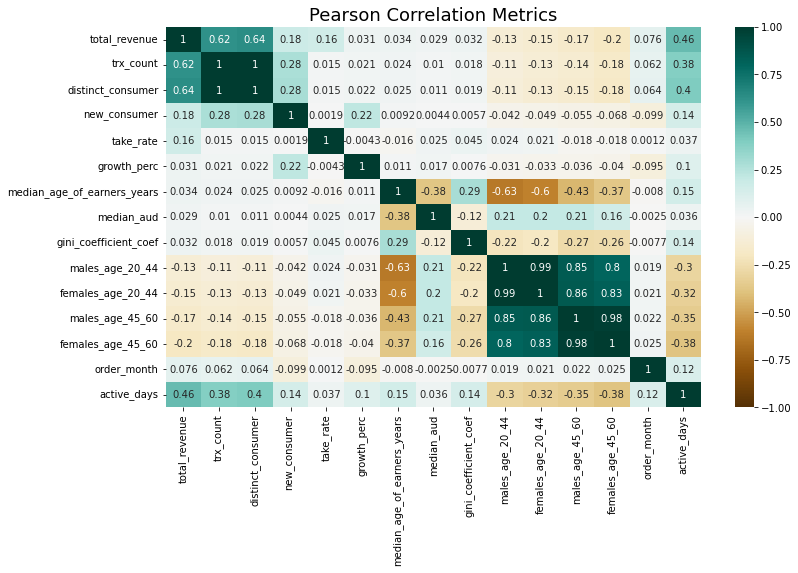

In [23]:
fields = ['total_revenue', 'trx_count', 'distinct_consumer', 'new_consumer', 
          'take_rate', 'growth_perc', 'median_age_of_earners_years', 
          'median_aud', 'gini_coefficient_coef', 'males_age_20_44', 
          'females_age_20_44', 'males_age_45_60', 'females_age_45_60',
          'order_month', 'active_days']
plt.figure(figsize=(12,7))
sns.heatmap(all_df[fields].corr(method='pearson'), 
            vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Pearson Correlation Metrics', fontsize=18)
plt.show()

In [24]:
def fill_na_w_mean(df):
    '''
    Fill any na values in dataframe with the column mean
    '''
    for col in df.columns:
        if df[col].isna().sum() > 0:
            mean_value = df[col].mean()
            df[col].fillna(value=mean_value, inplace=True)

In [25]:
fill_na_w_mean(tech_df)
fill_na_w_mean(tech_df_test)
fill_na_w_mean(furniture_df)
fill_na_w_mean(furniture_df_test)
fill_na_w_mean(hobby_df)
fill_na_w_mean(hobby_df_test)

In [26]:
tech_df.to_csv('../data/curated/tech_df.csv')
furniture_df.to_csv('../data/curated/furniture_df.csv')
hobby_df.to_csv('../data/curated/hobby_df.csv')

tech_df_test.to_csv('../data/curated/tech_df_test.csv')
furniture_df_test.to_csv('../data/curated/furniture_df_test.csv')
hobby_df_test.to_csv('../data/curated/hobby_df_test.csv')